In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory

# Initialize rng
rng = np.random.default_rng(2023)

In [3]:
batch_size = 32 # This is a tunable hyperparameter
shape = (64, 64) # note we are reducing the size of the image

data_dir = r'/content/drive/MyDrive/Teaching/Online/DeepLearning/Assignment1/UCMerced_LandUse/split'

train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                       seed=rng.integers(500000),
                                                       image_size=shape,
                                                       batch_size=batch_size,
                                                       label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'val'),
                                                     seed=rng.integers(500000),
                                                     image_size=shape,
                                                     batch_size=batch_size,
                                                     label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'),
                                                      seed=rng.integers(500000),
                                                      image_size=shape,
                                                      batch_size=batch_size,
                                                      label_mode='categorical')

Found 1470 files belonging to 21 classes.
Found 315 files belonging to 21 classes.
Found 315 files belonging to 21 classes.


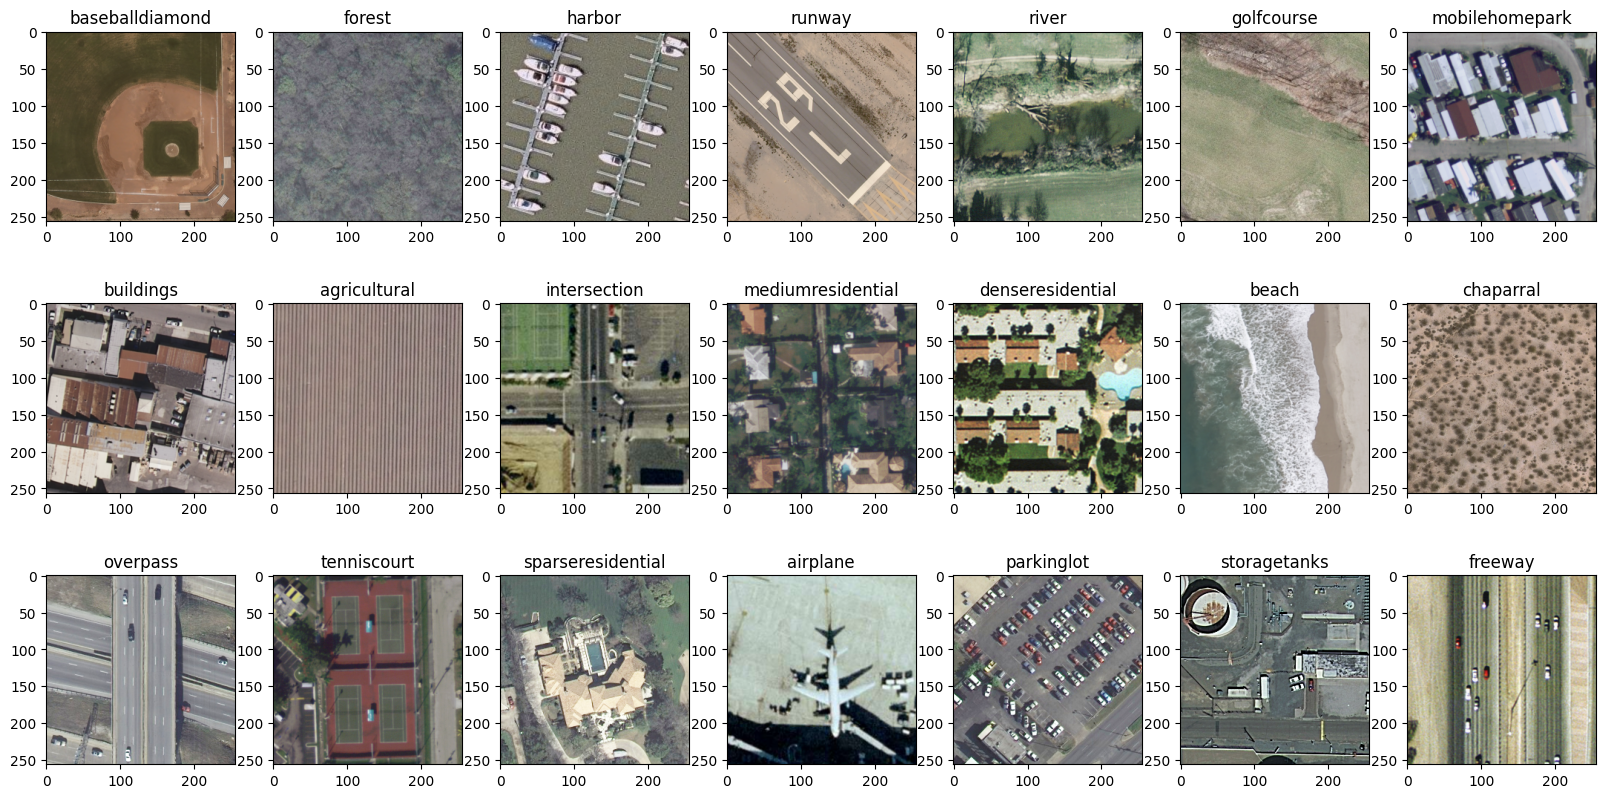

In [3]:
# Visualize some images
fig, ax = plt.subplots(3,7, figsize=(20, 10))

train_dir = os.path.join(data_dir, 'train')
i = 0
j = 0
for class_name in [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]:
  im = plt.imread(os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0]))
  ax[i][j].imshow(im);
  ax[i][j].set_title(class_name);

  j += 1
  if j>6:
    j = 0
    i += 1

# Start your solution below

### Following code shows sample solutions for every component that you need to implement and not complete solutions.

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt

#### Model with one hidden layer

In [17]:
# Model with one hidden layer
inputs = Input(shape=(64, 64, 3))
flatten = Flatten()(inputs)
layer1 = Dense(100, activation='sigmoid')(flatten)
outputs = Dense(21, activation='softmax')(layer1)

# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.01)

model = Model(inputs, outputs)

model.summary()

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_12 (Dense)            (None, 100)               1228900   
                                                                 
 dense_13 (Dense)            (None, 21)                2121      
                                                                 
Total params: 1231021 (4.70 MB)
Trainable params: 1231021 (4.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model.fit(train_ds,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
46/46 [==============================] - 8s 127ms/step - loss: 3.1934 - accuracy: 0.0408 - val_loss: 3.1581 - val_accuracy: 0.0476
Epoch 2/20
46/46 [==============================] - 6s 108ms/step - loss: 3.1730 - accuracy: 0.0374 - val_loss: 3.1885 - val_accuracy: 0.0476
Epoch 3/20
46/46 [==============================] - 5s 104ms/step - loss: 3.1465 - accuracy: 0.0401 - val_loss: 3.1222 - val_accuracy: 0.0476
Epoch 4/20
46/46 [==============================] - 6s 102ms/step - loss: 3.1424 - accuracy: 0.0442 - val_loss: 3.1299 - val_accuracy: 0.0476
Epoch 5/20
46/46 [==============================] - 8s 157ms/step - loss: 3.1507 - accuracy: 0.0408 - val_loss: 3.1593 - val_accuracy: 0.0476
Epoch 6/20
46/46 [==============================] - 5s 104ms/step - loss: 3.1734 - accuracy: 0.0497 - val_loss: 3.0992 - val_accuracy: 0.0476
Epoch 7/20
46/46 [==============================] - 6s 123ms/step - loss: 3.1529 - accuracy: 0.0449 - val_loss: 3.1402 - val_accuracy: 0.0476
Epoch 

In [5]:
# plot loss and accuracy curves
def summarize_training(history):
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title('Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='test')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot accuracy
  ax[1].set_title('Classification Accuracy', fontsize=20)
  ax[1].plot(history.history['accuracy'], label='train')
  ax[1].plot(history.history['val_accuracy'], label='test')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('Accuracy', fontsize=15)
  ax[1].legend(fontsize=15)

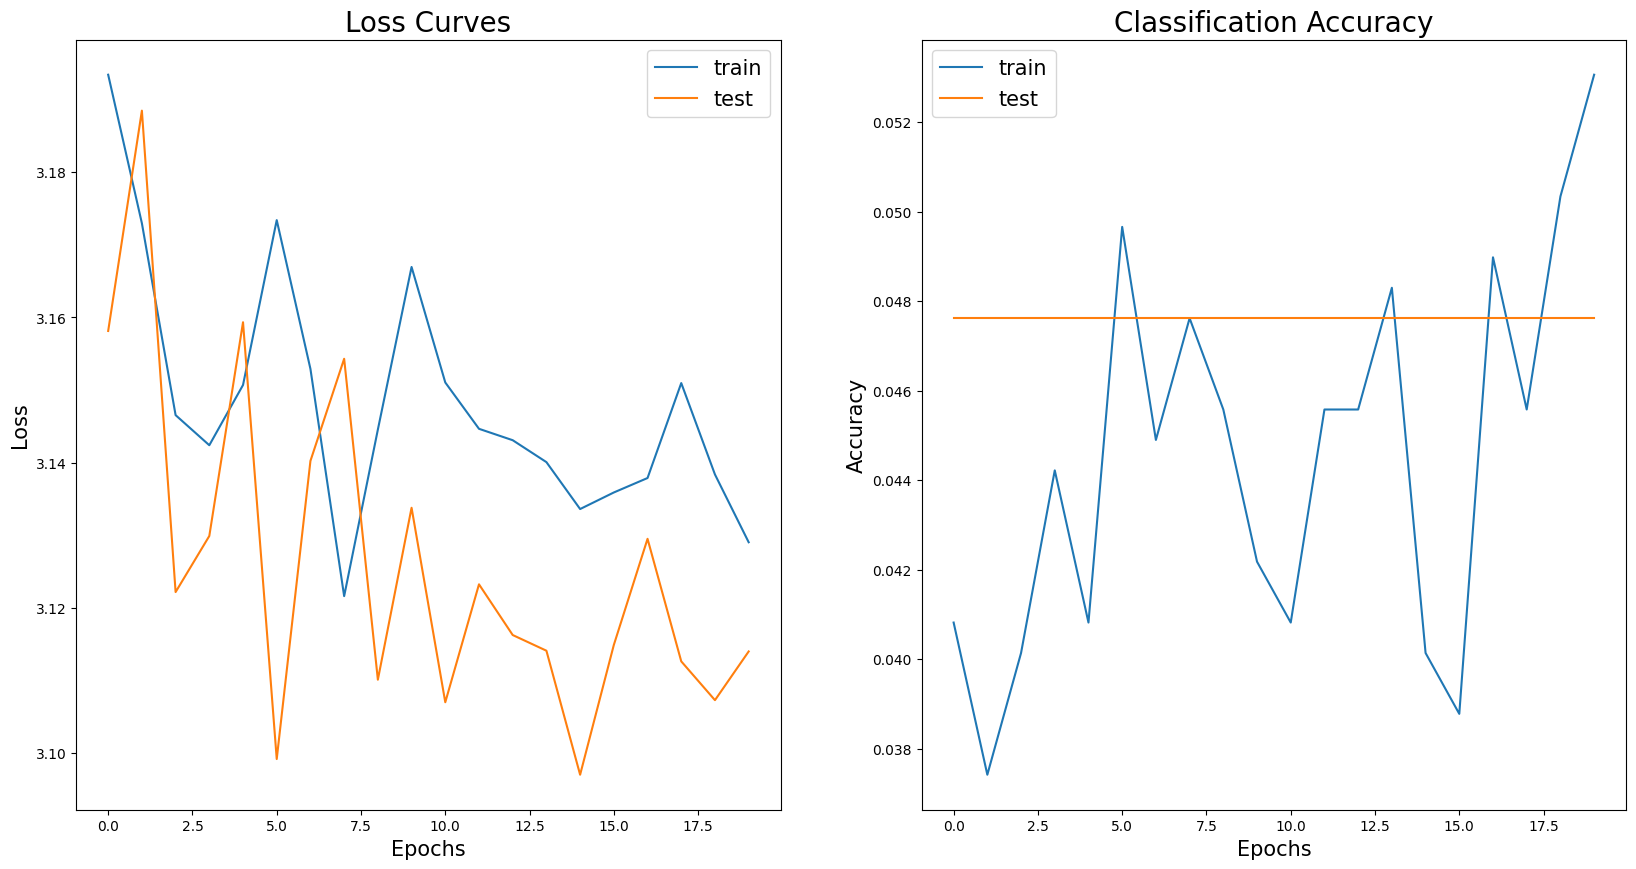

In [20]:
summarize_training(history)

In [6]:
def evaluate_model(model, ds):
  y_pred_class = []
  y_pred = []
  labels = []
  labels_one_hot = []
  for x, y in ds:
      y_pred_class.append(np.argmax(model(x), axis=-1)) # Use this line to get predicted class labels
      y_pred.append(model(x)) # Use this line to get model predictions as probabilities
      labels.append(np.argmax(y.numpy(), axis=-1))
      labels_one_hot.append(y.numpy())

  predictions = np.concatenate(y_pred, axis=0)
  pred_classes = np.concatenate(y_pred_class, axis=0)
  gt_labels = np.concatenate(labels, axis=0)
  gt_labels_one_hot = np.concatenate(labels_one_hot, axis=0)

  acc = accuracy_score(gt_labels, pred_classes)
  roc_auc = roc_auc_score(gt_labels, predictions, multi_class='ovr')

  return predictions, gt_labels_one_hot, acc, roc_auc

In [31]:
predictions, gt_labels, test_acc, test_roc_auc = evaluate_model(model, test_ds)

In [32]:
print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_roc_auc)

Test accuracy: 0.047619047619047616
Test ROC AUC: 0.5003174603174604


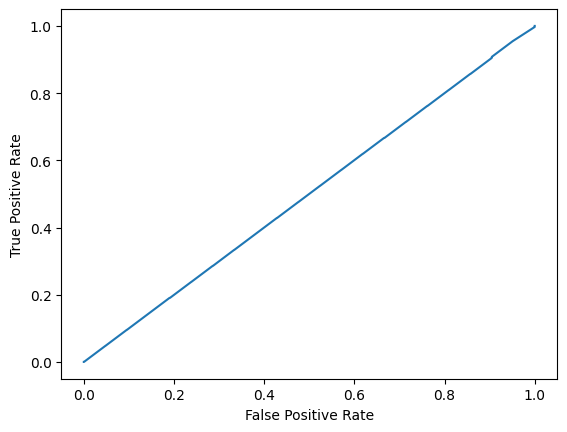

In [46]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");

#### Model with two hidden layers

In [53]:
# Model with two hidden layers
inputs = Input(shape=(64, 64, 3))
flatten = Flatten()(inputs)
layer1 = Dense(100, activation='relu')(flatten)
layer2 = Dense(100, activation='relu')(layer1)
outputs = Dense(21, activation='softmax')(layer2)

# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.01)

model = Model(inputs, outputs)

model.summary()

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 flatten_10 (Flatten)        (None, 12288)             0         
                                                                 
 dense_23 (Dense)            (None, 100)               1228900   
                                                                 
 dense_24 (Dense)            (None, 100)               10100     
                                                                 
 dense_25 (Dense)            (None, 21)                2121      
                                                                 
Total params: 1241121 (4.73 MB)
Trainable params: 1241121 (4.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history = model.fit(train_ds,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
46/46 [==============================] - 8s 115ms/step - loss: 3834.8115 - accuracy: 0.0497 - val_loss: 3.0478 - val_accuracy: 0.0476
Epoch 2/20
46/46 [==============================] - 5s 101ms/step - loss: 3.6285 - accuracy: 0.0381 - val_loss: 3.0462 - val_accuracy: 0.0476
Epoch 3/20
46/46 [==============================] - 7s 126ms/step - loss: 3.0470 - accuracy: 0.0476 - val_loss: 3.0456 - val_accuracy: 0.0476
Epoch 4/20
46/46 [==============================] - 5s 99ms/step - loss: 3.0469 - accuracy: 0.0429 - val_loss: 3.0449 - val_accuracy: 0.0476
Epoch 5/20
46/46 [==============================] - 6s 107ms/step - loss: 3.0462 - accuracy: 0.0449 - val_loss: 3.0447 - val_accuracy: 0.0476
Epoch 6/20
46/46 [==============================] - 6s 122ms/step - loss: 3.0465 - accuracy: 0.0333 - val_loss: 3.0447 - val_accuracy: 0.0476
Epoch 7/20
46/46 [==============================] - 5s 99ms/step - loss: 3.0465 - accuracy: 0.0361 - val_loss: 3.0447 - val_accuracy: 0.0476
Epoch

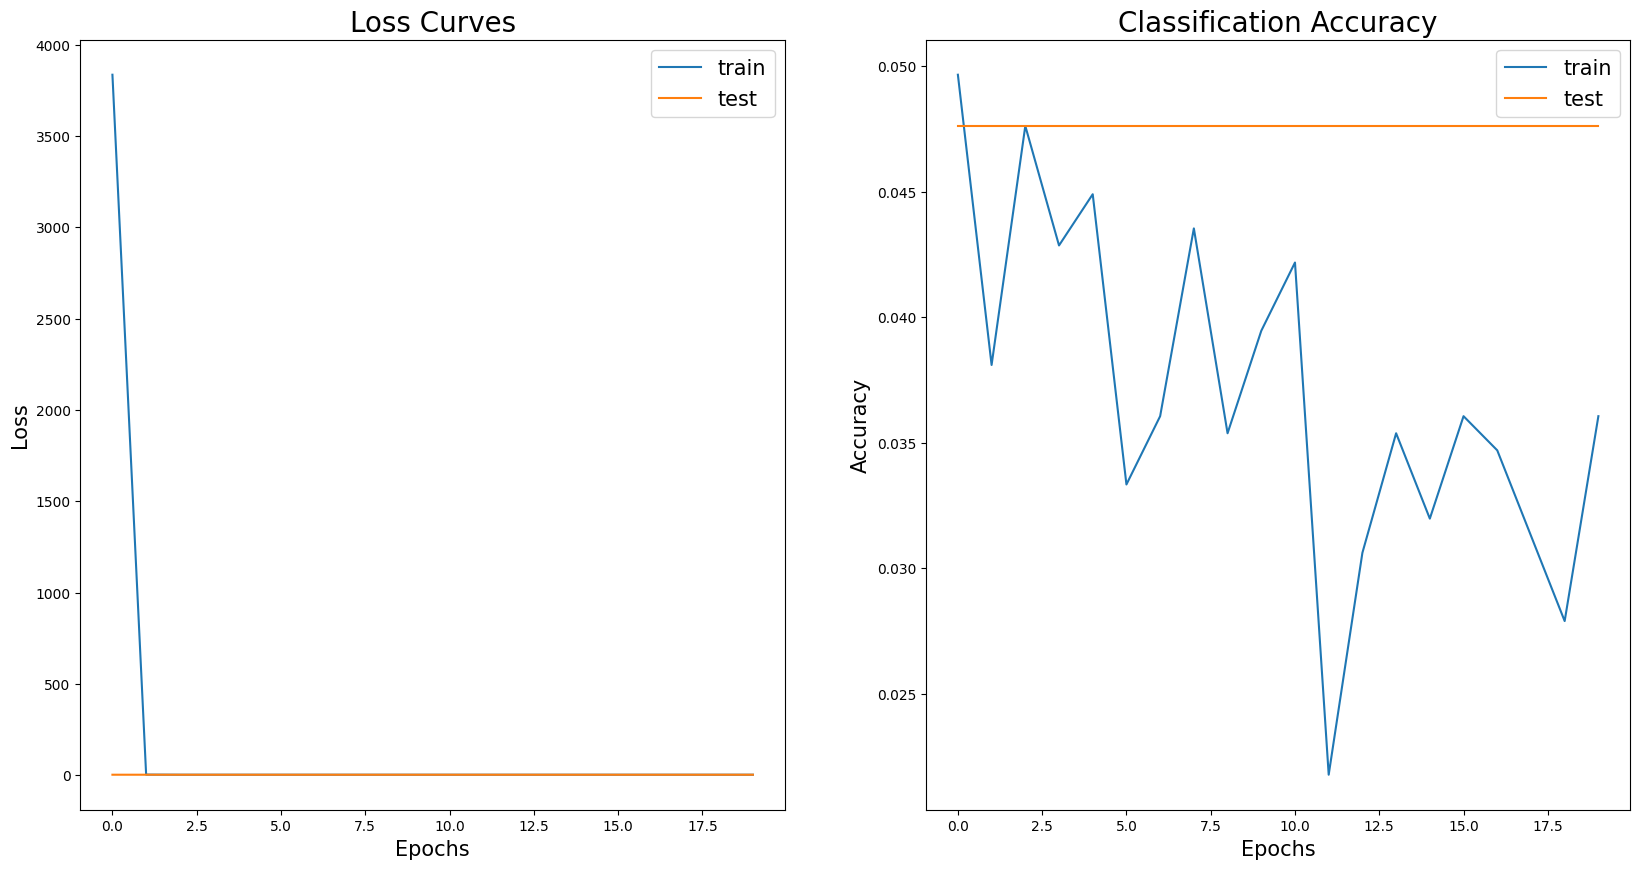

In [55]:
summarize_training(history)

In [64]:
predictions, gt_labels, test_acc, test_roc_auc = evaluate_model(model, test_ds)
print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_roc_auc)

Test accuracy: 0.047619047619047616
Test ROC AUC: 0.5014285714285714


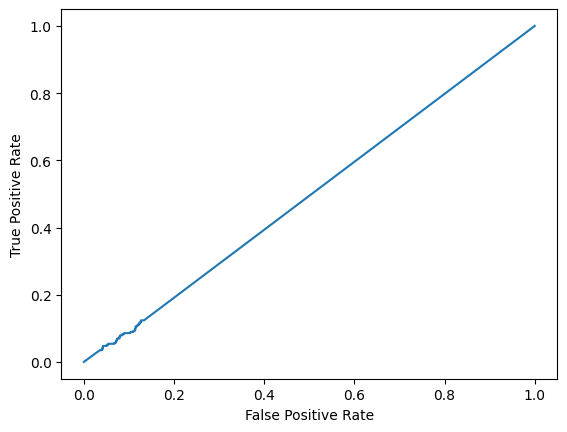

In [58]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");

#### Model with two hidden layers + dropout

In [75]:
# Model with two hidden layers + dropout
inputs = Input(shape=(64, 64, 3))
flatten = Flatten()(inputs)
fc1 = Dense(100, activation='tanh')(flatten)
dropout1 = Dropout(0.2)(fc1)
fc2 = Dense(100, activation='tanh')(dropout1)
dropout2 = Dropout(0.2)(fc2)
outputs = Dense(21, activation='softmax')(dropout2)

# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.001)

model = Model(inputs, outputs)

model.summary()

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 flatten_15 (Flatten)        (None, 12288)             0         
                                                                 
 dense_38 (Dense)            (None, 100)               1228900   
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_40 (Dense)            (None, 21)                212

In [76]:
history = model.fit(train_ds,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
46/46 [==============================] - 7s 109ms/step - loss: 3.3135 - accuracy: 0.0435 - val_loss: 3.0813 - val_accuracy: 0.0476
Epoch 2/20
46/46 [==============================] - 6s 126ms/step - loss: 3.2412 - accuracy: 0.0442 - val_loss: 3.0648 - val_accuracy: 0.0476
Epoch 3/20
46/46 [==============================] - 6s 100ms/step - loss: 3.1963 - accuracy: 0.0456 - val_loss: 3.0670 - val_accuracy: 0.0476
Epoch 4/20
46/46 [==============================] - 7s 136ms/step - loss: 3.2175 - accuracy: 0.0463 - val_loss: 3.0671 - val_accuracy: 0.0476
Epoch 5/20
46/46 [==============================] - 5s 99ms/step - loss: 3.2267 - accuracy: 0.0374 - val_loss: 3.0727 - val_accuracy: 0.0476
Epoch 6/20
46/46 [==============================] - 8s 160ms/step - loss: 3.2063 - accuracy: 0.0422 - val_loss: 3.0591 - val_accuracy: 0.0476
Epoch 7/20
46/46 [==============================] - 8s 168ms/step - loss: 3.1968 - accuracy: 0.0442 - val_loss: 3.0595 - val_accuracy: 0.0476
Epoch 8

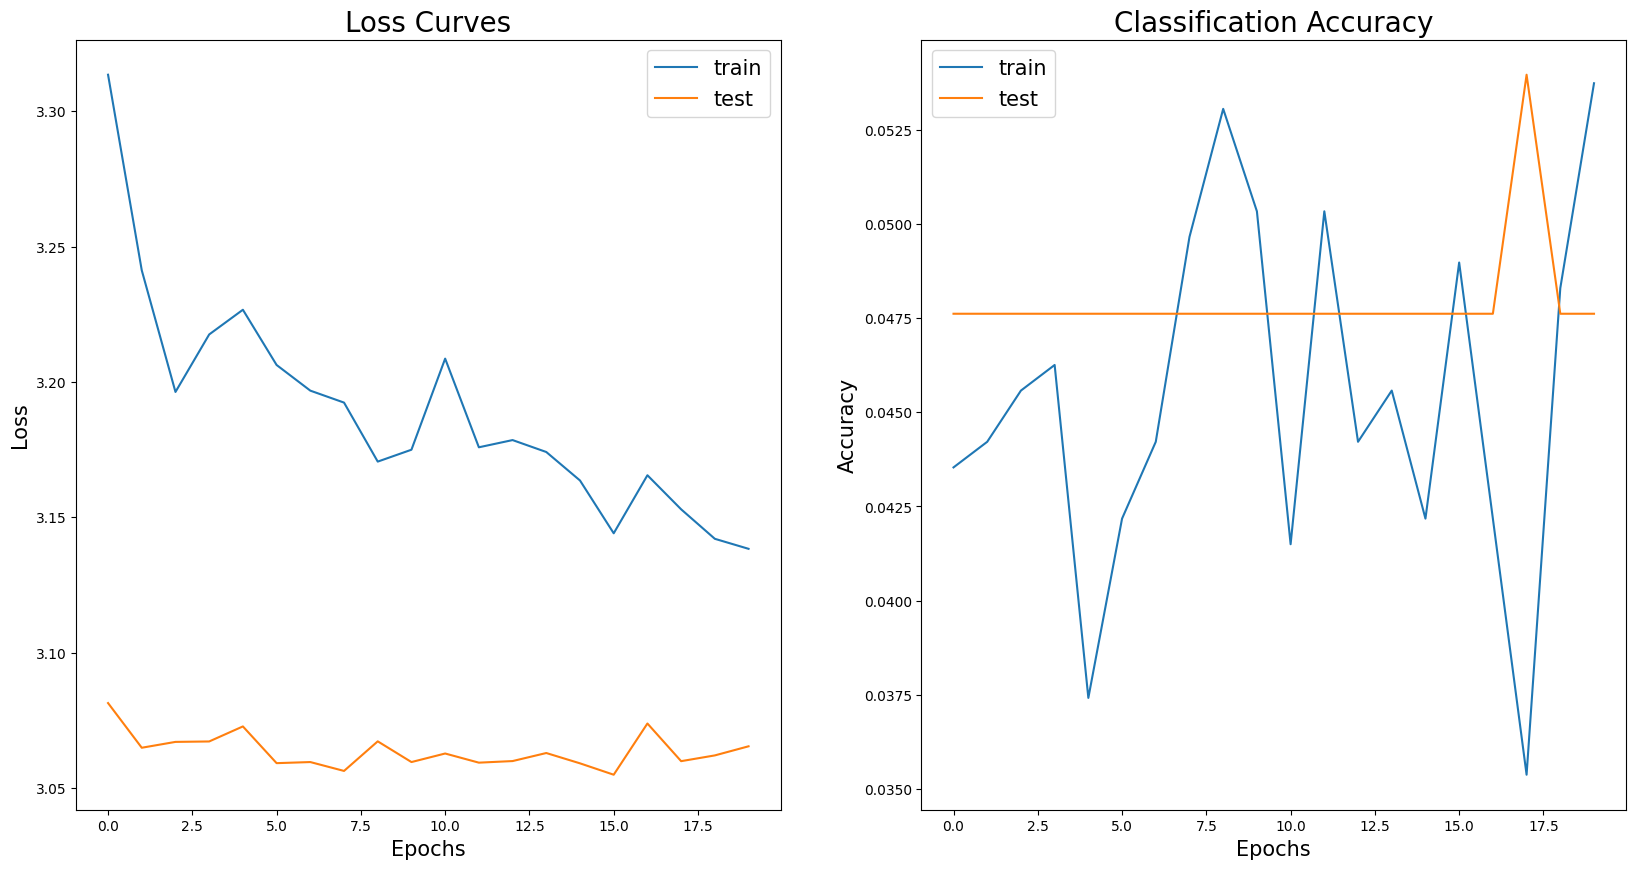

In [77]:
summarize_training(history)

In [78]:
predictions, gt_labels, test_acc, test_roc_auc = evaluate_model(model, test_ds)
print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_roc_auc)

Test accuracy: 0.047619047619047616
Test ROC AUC: 0.4974603174603174


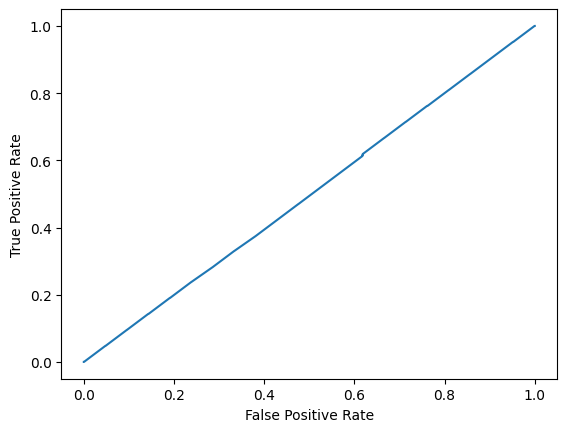

In [79]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");

#### Model with two hidden layers + batch norm + dropout

In [68]:
# Model with two hidden layers + batch norm + dropout
inputs = Input(shape=(64, 64, 3))
flatten = Flatten()(inputs)
fc1 = Dense(100, activation='relu')(flatten)
bn1 = BatchNormalization()(fc1)
dropout1 = Dropout(0.2)(bn1)
fc2 = Dense(100, activation='relu')(dropout1)
bn2 = BatchNormalization()(fc2)
dropout2 = Dropout(0.2)(bn2)
outputs = Dense(21, activation='softmax')(dropout2)

# early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=10,
                   restore_best_weights=True)

# define optimizer
opt = Adam(learning_rate=0.001)

model = Model(inputs, outputs)

model.summary()

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 flatten_14 (Flatten)        (None, 12288)             0         
                                                                 
 dense_35 (Dense)            (None, 100)               1228900   
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_36 (Dense)            (None, 100)               10100     
                                                          

In [69]:
history = model.fit(train_ds,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=val_ds,
                    callbacks=[es],
                    verbose=1)

Epoch 1/20
46/46 [==============================] - 116s 2s/step - loss: 3.2622 - accuracy: 0.1245 - val_loss: 8.8933 - val_accuracy: 0.0667
Epoch 2/20
46/46 [==============================] - 8s 163ms/step - loss: 2.6581 - accuracy: 0.2224 - val_loss: 5.1347 - val_accuracy: 0.0952
Epoch 3/20
46/46 [==============================] - 6s 100ms/step - loss: 2.3696 - accuracy: 0.2959 - val_loss: 3.2979 - val_accuracy: 0.1206
Epoch 4/20
46/46 [==============================] - 8s 156ms/step - loss: 2.2002 - accuracy: 0.3388 - val_loss: 4.3186 - val_accuracy: 0.0667
Epoch 5/20
46/46 [==============================] - 7s 130ms/step - loss: 2.1014 - accuracy: 0.3694 - val_loss: 4.3599 - val_accuracy: 0.0698
Epoch 6/20
46/46 [==============================] - 7s 119ms/step - loss: 2.0170 - accuracy: 0.4014 - val_loss: 4.7184 - val_accuracy: 0.0921
Epoch 7/20
46/46 [==============================] - 5s 100ms/step - loss: 1.9397 - accuracy: 0.4102 - val_loss: 5.5611 - val_accuracy: 0.1079
Epoch 8

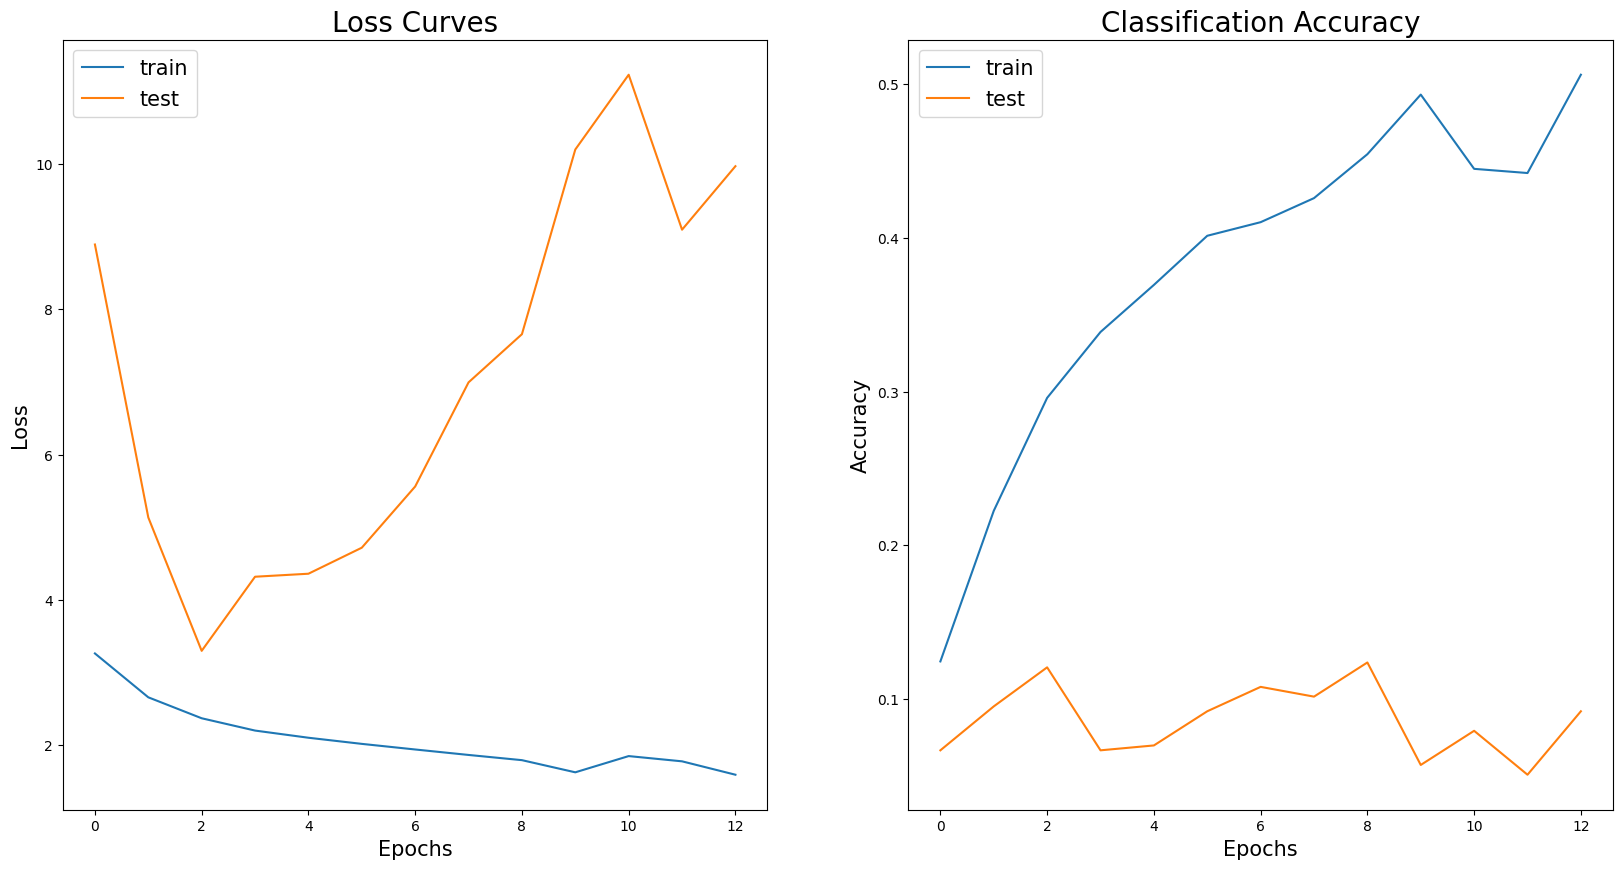

In [70]:
summarize_training(history)

In [73]:
predictions, gt_labels, test_acc, test_roc_auc = evaluate_model(model, test_ds)
print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_roc_auc)

Test accuracy: 0.13015873015873017
Test ROC AUC: 0.7651640211640212


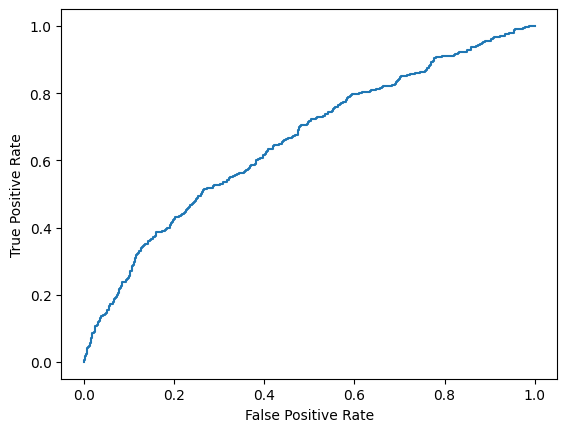

In [74]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");

#### Sample code for tuning hyperparameters

In [7]:
!pip install -q -U keras-tuner

In [8]:
from tensorflow import keras
import keras_tuner as kt

In [9]:
def model_builder(hp):
  inputs = Input(shape=(64, 64, 3))
  flatten = Flatten()(inputs)

  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_activation1 = hp.Choice('activation1', values=['relu', 'sigmoid', 'tanh', 'linear'])
  fc1 = Dense(hp_units1, activation=hp_activation1)(flatten)

  bn1 = BatchNormalization()(fc1)

  hp_dropout_rate1 = hp.Choice('dropout_rate1', values=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
  dropout1 = Dropout(hp_dropout_rate1)(bn1)

  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_activation2 = hp.Choice('activation2', values=['relu', 'sigmoid', 'tanh', 'linear'])
  fc2 = Dense(hp_units2, activation=hp_activation2)(dropout1)

  bn2 = BatchNormalization()(fc2)

  hp_dropout_rate2 = hp.Choice('dropout_rate2', values=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
  dropout2 = Dropout(hp_dropout_rate2)(bn2)

  outputs = Dense(21, activation='softmax')(dropout2)

  model = Model(inputs, outputs)


  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [10]:
tuner = kt.RandomSearch(model_builder,
                        objective='val_accuracy',
                        directory='my_dir',
                        max_trials = 10)

In [11]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=0,
                   patience=5,
                   restore_best_weights=True)

tuner.search(train_ds,
             epochs=10,
             validation_data=val_ds,
             callbacks=[es])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [12]:
print(best_hps.get('units1'),
      best_hps.get('activation1'),
      best_hps.get('dropout_rate1'),
      best_hps.get('units2'),
      best_hps.get('activation2'),
      best_hps.get('dropout_rate2'),
      best_hps.get('learning_rate'))

512 linear 0.25 128 relu 0.1 0.0001


In [13]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
46/46 [==============================] - 19s 170ms/step - loss: 3.1664 - accuracy: 0.1585 - val_loss: 14.0081 - val_accuracy: 0.0984
Epoch 2/50
46/46 [==============================] - 5s 101ms/step - loss: 2.1357 - accuracy: 0.3857 - val_loss: 5.9923 - val_accuracy: 0.1270
Epoch 3/50
46/46 [==============================] - 8s 159ms/step - loss: 1.6392 - accuracy: 0.5313 - val_loss: 5.0084 - val_accuracy: 0.1143
Epoch 4/50
46/46 [==============================] - 5s 99ms/step - loss: 1.2651 - accuracy: 0.6707 - val_loss: 3.9132 - val_accuracy: 0.1587
Epoch 5/50
46/46 [==============================] - 5s 102ms/step - loss: 0.9795 - accuracy: 0.7707 - val_loss: 4.0938 - val_accuracy: 0.1841
Epoch 6/50
46/46 [==============================] - 13s 230ms/step - loss: 0.7934 - accuracy: 0.8333 - val_loss: 3.3575 - val_accuracy: 0.2063
Epoch 7/50
46/46 [==============================] - 6s 113ms/step - loss: 0.6719 - accuracy: 0.8660 - val_loss: 4.1448 - val_accuracy: 0.1683
Epoc

In [14]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_ds,
               epochs=best_epoch,
               validation_data=val_ds)

Epoch 1/46
46/46 [==============================] - 8s 104ms/step - loss: 3.1222 - accuracy: 0.1741 - val_loss: 9.4248 - val_accuracy: 0.1206
Epoch 2/46
46/46 [==============================] - 7s 146ms/step - loss: 2.0793 - accuracy: 0.3898 - val_loss: 6.1663 - val_accuracy: 0.0952
Epoch 3/46
46/46 [==============================] - 5s 100ms/step - loss: 1.5892 - accuracy: 0.5422 - val_loss: 4.3913 - val_accuracy: 0.1746
Epoch 4/46
46/46 [==============================] - 8s 170ms/step - loss: 1.2539 - accuracy: 0.6599 - val_loss: 3.9554 - val_accuracy: 0.1556
Epoch 5/46
46/46 [==============================] - 9s 180ms/step - loss: 0.9902 - accuracy: 0.7633 - val_loss: 3.5886 - val_accuracy: 0.2032
Epoch 6/46
46/46 [==============================] - 7s 123ms/step - loss: 0.7682 - accuracy: 0.8422 - val_loss: 3.9187 - val_accuracy: 0.1619
Epoch 7/46
46/46 [==============================] - 5s 102ms/step - loss: 0.6286 - accuracy: 0.8762 - val_loss: 2.9030 - val_accuracy: 0.2127
Epoch 

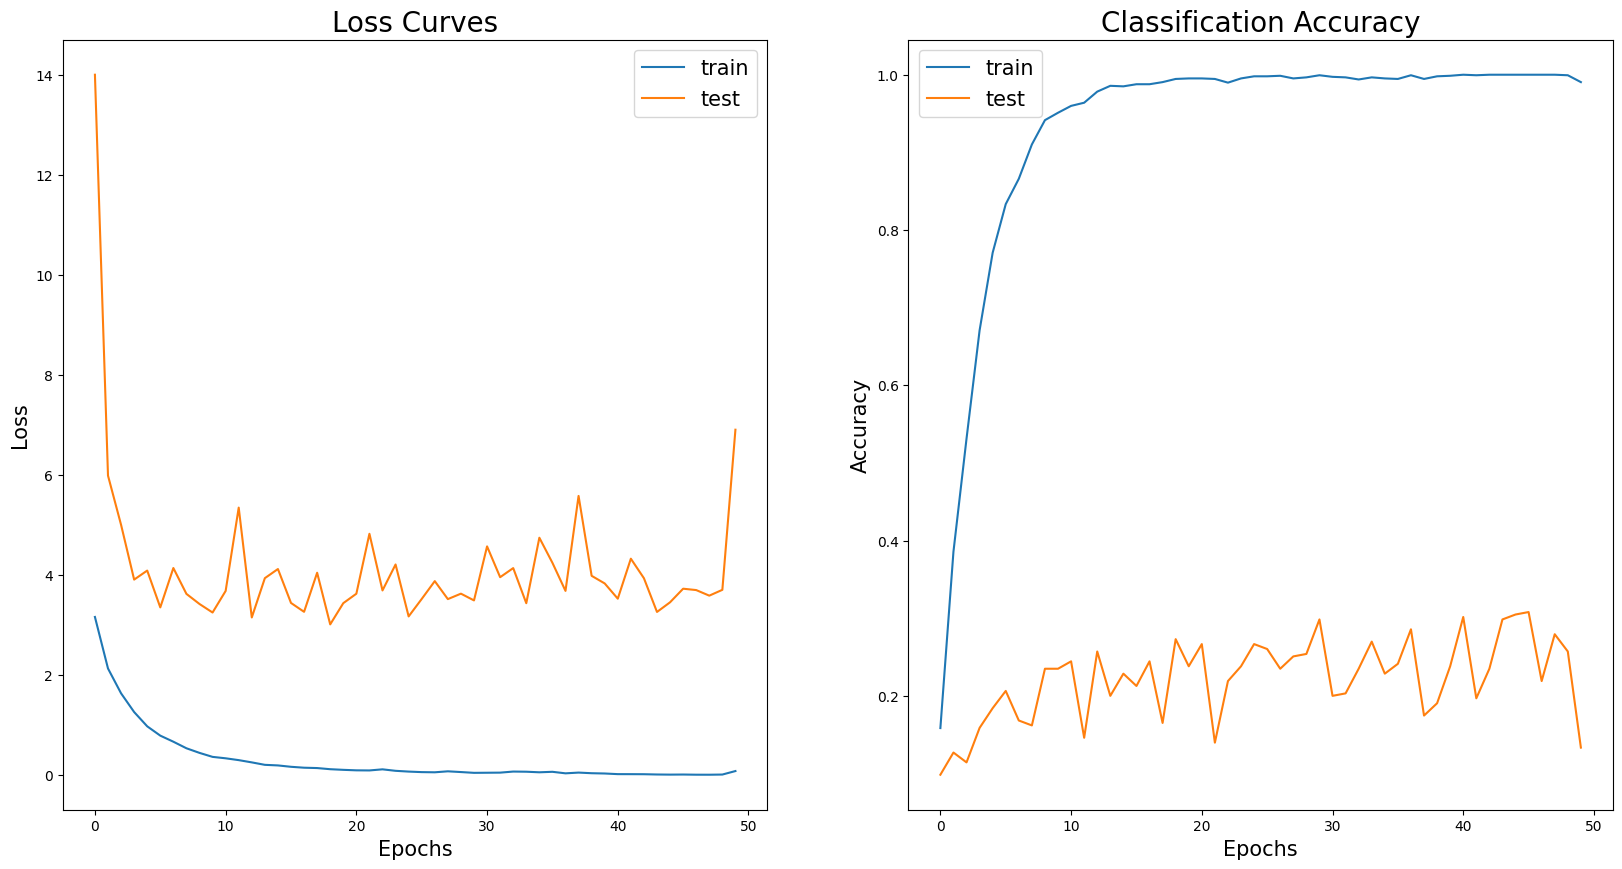

In [15]:
summarize_training(history)

In [16]:
predictions, gt_labels, test_acc, test_roc_auc = evaluate_model(model, test_ds)
print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_roc_auc)

Test accuracy: 0.1523809523809524
Test ROC AUC: 0.6876296296296297


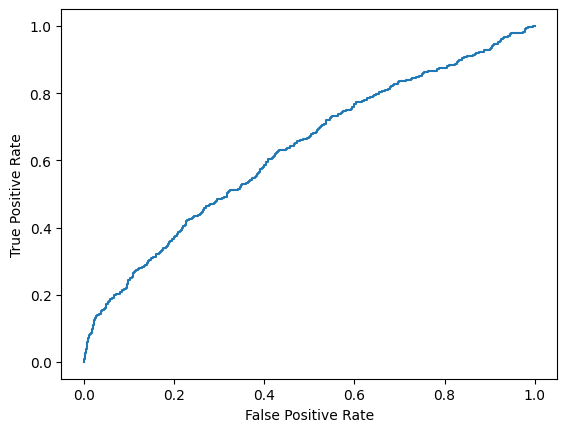

In [17]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(gt_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.plot(fpr["micro"], tpr["micro"]);
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");